Data Mining Mini Project: Web Scraping
-

Name: Mikollito Ong
-

Student ID: 1103558
-

# Objective: 
The objective of this project is to apply web scraping techniques using the BeautifulSoup library to extract product information from a dummy e-commerce website (https://books.toscrape.com/). 
After collecting the data, we aim to apply a data mining technique (specifically Association Rule Mining) to uncover interesting relationships between product attributes such as price range, user rating, and stock availability. This process demonstrates how publicly available web data can be used for pattern discovery and business insights.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [2]:
url = "https://books.toscrape.com/"
response = requests.get(url)
soup = BeautifulSoup(response.text, "html.parser")

books = soup.find_all("article", class_="product_pod")

book_data = []

for book in books:
    title = book.h3.a["title"]
    price = book.find("p", class_="price_color").text
    availability = book.find("p", class_="instock availability").text.strip()
    rating = book.p.get("class")[1]  # 'star-rating Three' -> 'Three'

    book_data.append({
        "Title": title,
        "Price": price,
        "Availability": availability,
        "Rating": rating
    })

df = pd.DataFrame(book_data)
df.head()


,Title,Price,Availability,Rating
0,A Light in the Attic,Â£51.77,In stock,Three
1,Tipping the Velvet,Â£53.74,In stock,One
2,Soumission,Â£50.10,In stock,One
3,Sharp Objects,Â£47.82,In stock,Four
4,Sapiens: A Brief History of Humankind,Â£54.23,In stock,Five


In [3]:
df.to_csv("books_scraped.csv", index=False)
print("Saved scraped data to books_scraped.csv")


Saved scraped data to books_scraped.csv


In [7]:
# Association Rule Mining
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import re

# Clean price: remove non-numeric characters like £ or Â using regex
df['Price_Num'] = df['Price'].apply(lambda x: float(re.sub(r'[^\d.]', '', x)))

# Create a new 'Price_Range' column based on price thresholds
def categorize_price(price):
    if price < 20:
        return 'Low'
    elif 20 <= price <= 35:
        return 'Medium'
    else:
        return 'High'

df['Price_Range'] = df['Price_Num'].apply(categorize_price)

# One-hot encode selected categorical features
df_rules = pd.get_dummies(df[['Price_Range', 'Rating', 'Availability']])

# Run Apriori to find frequent itemsets
frequent_itemsets = apriori(df_rules, min_support=0.1, use_colnames=True)

# Generate association rules with lift ≥ 1
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Display top 5 rules
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head()


C:\Users\miko9\anaconda3\envs\text_mining\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


,antecedents,consequents,support,confidence,lift
0,(Rating_Five),(Price_Range_High),0.15,0.750000,1.250000
1,(Price_Range_High),(Rating_Five),0.15,0.250000,1.250000
2,(Rating_One),(Price_Range_High),0.20,0.666667,1.111111
3,(Price_Range_High),(Rating_One),0.20,0.333333,1.111111
4,(Rating_Three),(Price_Range_High),0.10,0.666667,1.111111


Antecedent: (Rating_Five)
Consequent: (Price_Range_High)
Support: 0.15 (15% of all books are both 5-Star and part of the high price range)
Confidence: 0.75 (75% of 5-star books are also high priced)
Lift: 1.25 (This combination occurs 25% more often than random chance)

Antecedent: (Price_Range_High)
Consequent: (Rating_Five)
Confidence: 0.25 (Only 25% of expensive books are 5-star) 
Observation: This means that while 5-star books tend to be expensive, not all expensive books are all 5-star

Antecedent: (Rating_One) 
Consequent: (Price_Range_High)
Confidence: 0.666 (66% of 1-star books are also expensive)

Summary:
The Apriori-based association rule mining revealed that 5-star rated books are strongly associated with high prices (75% confidence, 1.25 lift). Interestingly, even 1-star and 3-star books often fall in the high price range, suggesting that price is not a direct indicator of user satisfaction. These insights could help in understanding pricing strategy or user expectations for premium products.
---------------------------------------------------------------------------------

In [14]:
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head()


,antecedents,consequents,support,confidence,lift
0,(Rating_Five),(Price_Range_High),0.15,0.750000,1.250000
1,(Price_Range_High),(Rating_Five),0.15,0.250000,1.250000
2,(Rating_One),(Price_Range_High),0.20,0.666667,1.111111
3,(Price_Range_High),(Rating_One),0.20,0.333333,1.111111
4,(Rating_Three),(Price_Range_High),0.10,0.666667,1.111111


In [15]:

rules['Rule'] = rules['antecedents'].apply(lambda x: ', '.join(list(x))) + " → " + \
                rules['consequents'].apply(lambda x: ', '.join(list(x)))


C:\Users\miko9\AppData\Local\Temp\ipykernel_664\217462046.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Rule', x='confidence', data=top_rules, palette='viridis')


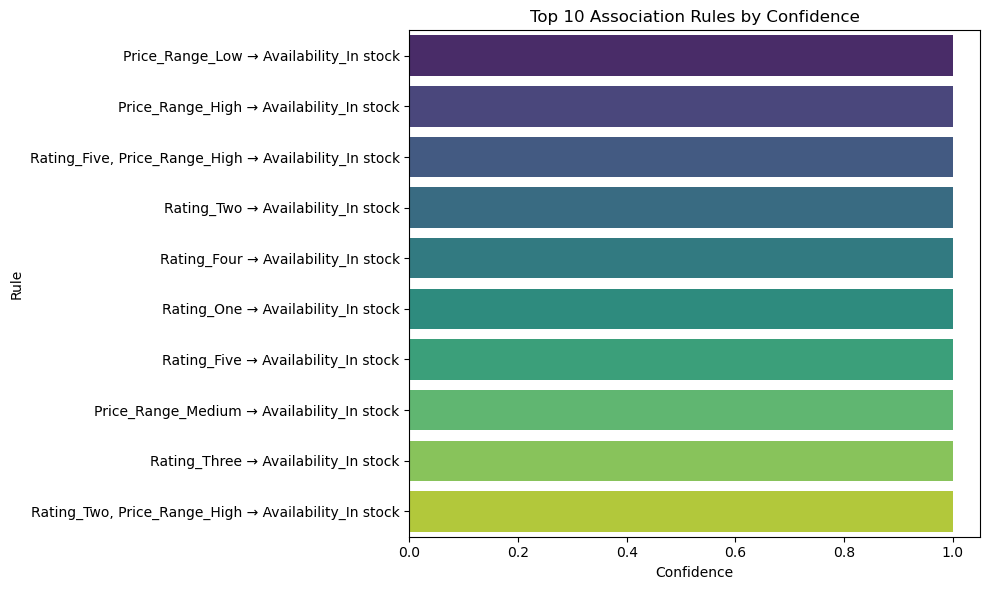

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort rules by confidence or lift
top_rules = rules.sort_values(by='confidence', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(y='Rule', x='confidence', data=top_rules, palette='viridis')
plt.title("Top 10 Association Rules by Confidence")
plt.xlabel("Confidence")
plt.ylabel("Rule")
plt.tight_layout()
plt.show()


The chart displays the top 10 association rules sorted by confidence. All the top rules suggest that books with various combinations of ratings and price ranges are strongly associated with being in stock. For instance, books in the Price_Range_High category or those rated Five are highly likely to be available, with a confidence value close to 1.

This suggests that the store tends to keep higher-rated or higher-priced books consistently in stock, possibly due to demand or perceived value. Such patterns can help optimize inventory strategies or promotional targeting.

